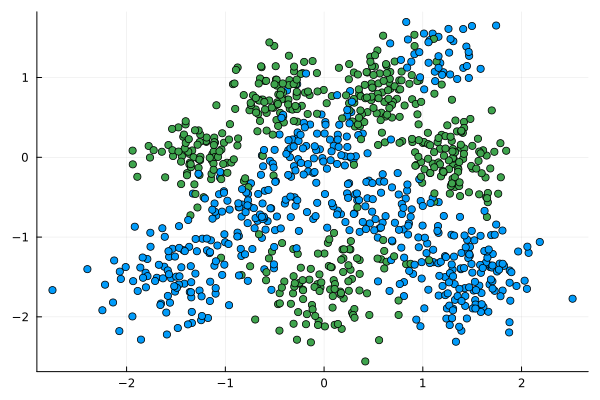

In [1]:
using DataFrames, CSV, DelimitedFiles
using Plots
using Zygote
using ForwardDiff

X = [ones(1000, 1) readdlm("X.txt", ' ', Float64)] 
y = readdlm("y.txt", ' ', Int64) .* 2 .- 1

scatter(X[:, 2], X[:, 3], markercolor=y.+2, legend=false)

## Regression

Model using:

$$ y = w^T X + b + \epsilon_n$$

where:

$$ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $$

by adding a third dimension to X, as done above, we can use:

$$ y = w^T \tilde{X} + \epsilon_n$$

Ultimately we have:

$$ p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) = \mathcal{N}(y_n | \mathbf{w}^t \tilde{\mathbf{x}}_n, \sigma^2) $$



## Logistic Regression

$$\begin{align*}
 p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) &= (1 +y_n) \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n) (1 - \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n))\\
&= (1 + y_n) \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n)  \sigma (-\mathbf{w}^T \tilde{\mathbf{x}}_n)\\
\end{align*}$$


In [2]:
logistic(X) = 1 / (1 + exp(-clamp.(X, -10_000, 10_000)))

likelihood(X, y, w) = logistic.(-y .* (X * w))

log_loss(X, y, w) = sum(log.(likelihood(X, y, w))) / size(X, 1)

log_loss (generic function with 1 method)

-1.7674808602058587


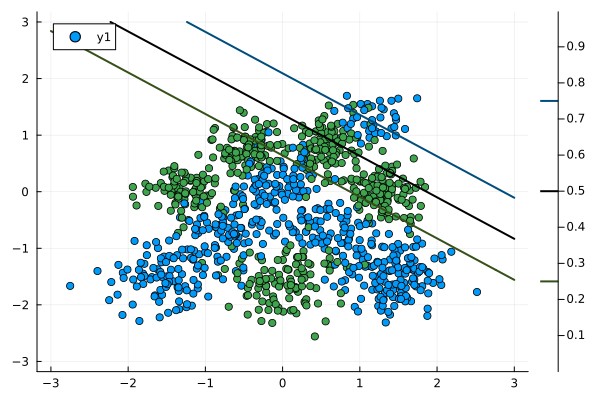

In [3]:
w = randn(3, 1)
predictions = logistic.(X * w)

println(log_loss(X, y, w))
scatter(X[:, 2], X[:, 3], markercolor=y.+2)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


In [4]:
# Gradient ascent
function train(Input, labels; lr=0.01, epochs=500)
    n_features = size(Input, 2)
    params = randn(n_features, 1) .* 0.1 / (1 * n_features) # Initialize weights
    println("Initial log likelihood = $(log_loss(Input, labels, params))")
    
    for i in 1:epochs
        lr = lr * 0.9999  # Decrease learning rate
        # Compute gradient using Zygote
        grad = Zygote.gradient(params -> log_loss(Input, labels, params), params)[1]

        # Update weights (ascent because we're maximizing)
        params .+= lr * grad

        # Print progress every 100 epochs
        if i % 100 == 0
            loss = log_loss(Input, labels, params)
            println("Epoch $i: log likelihood = $loss")
            
            
        end
    end
    println("Training complete.")
    println("Final log likelihood = $(log_loss(Input, labels, params))")
    return params
end

train (generic function with 1 method)

Initial log likelihood = -0.6933702784578216
Epoch 100: log likelihood = -0.6679815350756494
Epoch 200: log likelihood = -0.6532594773616403
Epoch 300: log likelihood = -0.6442051109705238
Epoch 400: log likelihood = -0.6383381323969111
Epoch 500: log likelihood = -0.6343716993402413
Training complete.
Final log likelihood = -0.6343716993402413


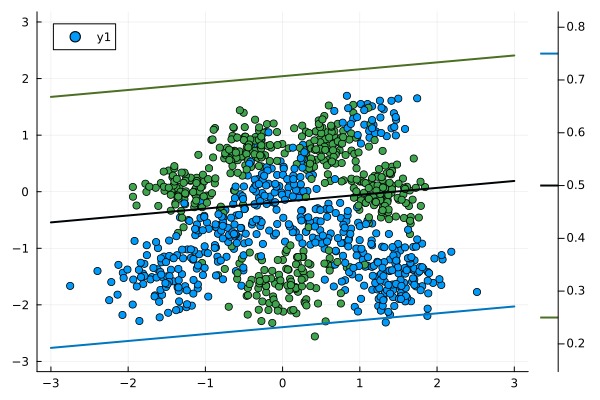

In [5]:
w_opt = train(X, y)
pred = logistic.(X * w_opt)

scatter(X[:, 2], X[:, 3], markercolor=y.+2)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w_opt)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


## Basis Functions

Expanding on the above result, we look at other basis functions that better capture non-linearities further from the origin


In [6]:
function evaluate_gaussian_basis_functions(l, X, Z)
    X2 = sum(X.^2, dims=2)
    Z2 = sum(Z.^2, dims=2)
    ones_Z = ones(size(Z, 1))
    ones_X = ones(size(X, 1))
    r2 = X2 * ones_Z' .- 2 * (X * Z') .+ ones_X * Z2'
    return exp.(-0.5 / l^2 .* r2)
end

evaluate_gaussian_basis_functions (generic function with 1 method)

Initial log likelihood = -0.6930208789137355
Epoch 100: log likelihood = -0.5608678874064132
Epoch 200: log likelihood = -0.5138092587325896
Epoch 300: log likelihood = -0.47856832006637295
Epoch 400: log likelihood = -0.45123162322952176
Epoch 500: log likelihood = -0.4294736795111932
Training complete.
Final log likelihood = -0.4294736795111932


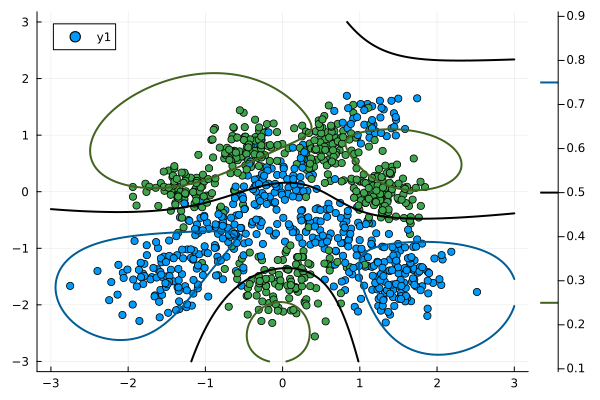

In [8]:
X_basis = evaluate_gaussian_basis_functions(1, X, X)
w_opt_basis = train(X_basis, y)
predictions = logistic.(X_basis * w_opt_basis)

scatter(X[:, 2], X[:, 3], markercolor=y.+2)

x_range = range(-3, 3, length=500)
y_range = range(-3, 3, length=500)
points = hcat(repeat(x_range, inner=length(y_range)), repeat(y_range, outer=length(x_range)))
points_basis = evaluate_gaussian_basis_functions(1, [ones(500^2) points], X)
points_predictions = logistic.(points_basis * w_opt_basis)
points_predictions_mesh = reshape(points_predictions, 500, 500)
contour!(x_range, y_range, points_predictions_mesh, levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)